In [76]:
from bs4 import BeautifulSoup
import csv
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from shapely.geometry import LineString, Point
import rtree

In [26]:
df_traffic = pd.read_csv('vt_2017_avg_daily_traffic_190919.csv', index_col=0)

In [3]:
df_collisions = pd.read_csv('vt_deer_collisions_2010_2019_190919.csv')

In [4]:
lat_list, lon_list = list(), list()
new_coords = list()
for coord in df_collisions.Coordinates[:]:
    if type(coord)==float:
        new_coords.append(coord)
        lat_list.append(np.nan)
        lon_list.append(np.nan)
    else:
        lat, lon = [float(i) for i in coord.split(',')]
        new_coords.append((lat, lon))
        lat_list.append(lat)
        lon_list.append(lon)

In [5]:
#df_collisions.Coordinates = new_coords
df_collisions['lat'] = lat_list
df_collisions['lon'] = lon_list

In [6]:
coords = df_collisions.dropna(axis='rows', subset=['Coordinates']).Coordinates

In [7]:
def process_coord_string(line_segment):
    """
    Take a coord string originally saved as a shapely line and spit out long/lat floats
    """
    path_points = list()
    #for i in df_traffic.loc[0, 'line'][12:-1].split(','):
    for i in line_segment[12:-1].split(','):
        lat, lon = [float(coord) for coord in i.strip().split(' ')]
        path_points.append(tuple([lat, lon]))
    return path_points

In [8]:
df_traffic['lat_lon_list'] = [process_coord_string(line_segment) for line_segment in df_traffic.line]

In [9]:
def process_lines(df):
    """Process placemark data from a KML file"""
    line_list, mid_list = list(), list()
    for index, row in df.iterrows():
        try:
            line = LineString(row['lat_lon_list'])
            line_list.append(line)
            mid_list.append(line.interpolate(0.5, normalized = True))
        except:
            print('no', end=' ')
            line_list = np.nan
            mid_list = np.nan
    df['line'] = line_list
    df['mid_point'] = mid_list

### Development of `process_lines`
```python
for index, row in df_traffic.iterrows():
    try:
        print('yes ', end='')
        #LineString(df_traffic.lat_lon_list[0])
        #print(row.lat_lon_list)
        df_traffic.loc[index, 'line'] = LineString(row.lat_lon_list)
        df_traffic.loc[index, 'mid_point'] = row.line.interpolate(0.5, normalized = True)
    except:
        df_traffic.loc[index, 'line'] = np.nan
        df_traffic.loc[index, 'mid_point'] = np.nan
```

In [10]:
process_lines(df_traffic)

In [11]:
test = df_traffic.dropna(axis='rows', subset=['line', 'mid_point'])

## Splitting `shapely` lines

In [12]:
from shapely.geometry import Point, LineString
def split_line(line, max_line_units):
    if line.length <= max_line_units:
        return [line]

    half_length = line.length / 2
    coords = list(line.coords)
    for idx, point in enumerate(coords):
        proj_dist = line.project(Point(point))
        if proj_dist == half_length:
            return [LineString(coords[:idx + 1]), LineString(coords[idx:])]

        if proj_dist > half_length:
            mid_point = line.interpolate(half_length)
            head_line = LineString(coords[:idx] + [(mid_point.x, mid_point.y)])
            tail_line = LineString([(mid_point.x, mid_point.y)] + coords[idx:])
            return split_line(head_line, max_line_units) + split_line(tail_line, max_line_units)

In [13]:
test_line = LineString(df_traffic.lat_lon_list[6])

In [14]:
split_line(test_line, 0.008)

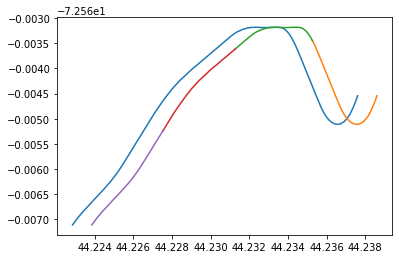

In [15]:
x, y = test_line.xy
plt.plot(x, y)
lines = split_line(test_line, 0.008)
for line in lines:
    x, y = line.xy
    plt.plot([x+.001 for x in x], y)
None

In [16]:
test_line.interpolate?

Signature: test_line.interpolate(distance, normalized=False)
Docstring:
Return a point at the specified distance along a linear geometry

If the normalized arg is True, the distance will be interpreted as a
fraction of the geometry's length.
File:      ~/.anaconda3/envs/inaturalist/lib/python3.7/site-packages/shapely/geometry/base.py
Type:      method


In [17]:
for line in split_line(test_line, 0.001):
    midpoint = line.interpolate(0.5, normalized=True)

In [18]:
midpoint.coords[:][0]

(44.223070344851465, -72.566991481502)

In [19]:
[line.interpolate(0.5).coords[:][0] for line in split_line(test_line, 0.001)]

[(44.23723499976448, -72.56489462740565),
 (44.23676439624631, -72.56509321250356),
 (44.236254626163536, -72.56506688743323),
 (44.23579784476763, -72.5648358610349),
 (44.235413531645776, -72.56449322685924),
 (44.235038424918265, -72.56414008466038),
 (44.23466349370195, -72.56378677522828),
 (44.2342739869851, -72.56345009009459),
 (44.2338170568704, -72.56321919935434),
 (44.233305012687914, -72.5631834682015),
 (44.23278986171804, -72.56318801427446),
 (44.23227471064502, -72.56318391711295),
 (44.23176077354632, -72.56321358795778),
 (44.23125367734019, -72.56330220846392),
 (44.230761400042184, -72.56345358845813),
 (44.23027175313903, -72.56361378170132),
 (44.22978178481661, -72.56377299046295),
 (44.229292068832784, -72.56393296327226),
 (44.22880366580732, -72.56409653009956),
 (44.22832019762378, -72.56427421650848),
 (44.22784939053227, -72.56448285980913),
 (44.22739214819086, -72.56472009686762),
 (44.22694644062355, -72.56497822167455),
 (44.2265091160778, -72.56525055

In [20]:
from mapboxgl.viz import *
from mapboxgl.utils import *
token = 'pk.eyJ1IjoiZGF0YXNsZXV0aCIsImEiOiJjazB0em1tbGUwaXdnM21yenJjdTJybm52In0.qm4lOhweUJZuaxgEl6lEwA'

In [21]:
temp = df_collisions.dropna(axis='rows', subset=['lat', 'lon'], how='any')[['lat', 'lon']]
geojson = df_to_geojson(temp, lat='lat', lon='lon', precision=10)

In [22]:
viz = CircleViz(geojson, access_token=token, 
                radius = 2, center = (temp.lon.mean(), temp.lat.mean()), 
                zoom = 7,
                below_layer='waterway-label')
viz.show()

/home/jeremy/.anaconda3/envs/inaturalist/lib/python3.7/site-packages/IPython/core/display.py:694: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


<Figure size 432x720 with 0 Axes>

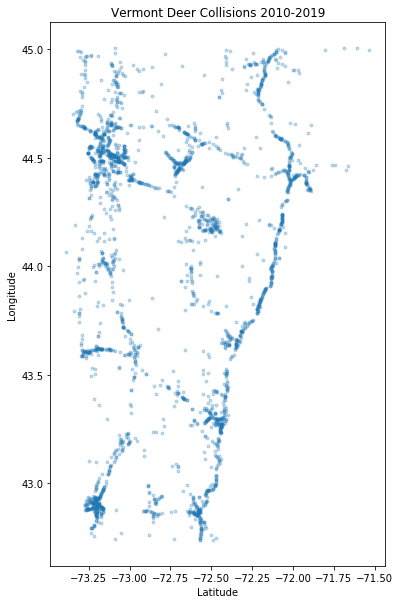

In [23]:
test = df_traffic#.dropna(axis='rows', subset=['lat_lon_list', 'line', 'mid_point'])

colors = plt.get_cmap('copper', lut=test.AADT.max())
plt.figure(figsize=(6,10))

"""for index, row in test.iterrows():    
    y, x = test.loc[index, 'line'].xy
    plt.plot(x, y, color=colors(int(test.loc[index, 'AADT'])))"""

plt.figure(figsize=(6,10))
plt.scatter(df_collisions.lon, df_collisions.lat, marker='.', alpha=.25)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Vermont Deer Collisions 2010-2019')
None

# Loading traffic data
Could make a script with this garbage

In [208]:
def process_coord_string(coord_string):
    """
    Take a coord string and spit out long/lat floats
    """
    space_splits = coord_string.split(' ')
    path_points = list()
    for split in space_splits:
        comma_split = split.split(',')
        lat = float(comma_split[1]) # lat
        lon = float(comma_split[0]) # long
        path_points.append(tuple([lon, lat]))
    return path_points

def process_place(placemark):
    """Process placemark data from a KML file"""
    place_dict = dict()
    for i in placemark.find_all('SimpleData'):
        place_dict[i['name']] = i.text
        
    try:
        place_dict['lat_lon_list'] = process_coord_string(placemark.find('coordinates').string)
        place_dict['line'] = LineString(place_dict['lat_lon_list'])
        place_dict['mid_point'] = place_dict['line'].interpolate(0.5, normalized = True)
        place_dict['length'] = place_dict['line'].length
    except:
        place_dict['lat_lon_list'] = np.nan
        place_dict['line'] = np.nan
        place_dict['mid_point'] = np.nan
        place_dict['length'] = np.nan

    return place_dict

In [137]:
### This is loaded above
#```python
with  open('VT_Annual_Average_Daily_Traffic_AADT__2017.kml', encoding='utf8') as f:
    s = BeautifulSoup(f, 'xml')
placemarks = s.find_all('Placemark')
place_list = [process_place(i) for i in placemarks]
df_traffic = pd.DataFrame(place_list)
#```

In [417]:
del s, placemarks, place_list

In [209]:
df_traffic.loc[0, 'line'].xy

(array('d', [-72.33550173848928, -72.33538821071163, -72.3352339446959, -72.33507899381742, -72.33476420095099]),
 array('d', [43.646995252339224, 43.646945854611815, 43.6468813667466, 43.64680772568318, 43.646645048106265]))

In [139]:
df_traffic.loc[0, 'lat_lon_list']

[(-72.33550173848928, 43.646995252339224),
 (-72.33538821071163, 43.646945854611815),
 (-72.3352339446959, 43.6468813667466),
 (-72.33507899381742, 43.64680772568318),
 (-72.33476420095099, 43.646645048106265)]

In [140]:
place_list[1]['length']

0.016697468652507572

In [41]:
_temp = place_list[1]['line'].interpolate(1/3., normalized=True)

In [42]:
type(_temp)

shapely.geometry.point.Point

In [43]:
place_list[1]['line'].interpolate(2/3., normalized=True).xy

(array('d', [44.57240806638649]), array('d', [-72.59816189203102]))

In [44]:
place_list[1]['line'].interpolate?

Object `interpolate` not found.


In [ ]:
place_list[1]['line'].interpolate

In [45]:
place_list[1]['line'].interpolate

<bound method BaseGeometry.interpolate of <shapely.geometry.linestring.LineString object at 0x7fb6fb570f50>>

In [46]:
thresh = 0.0095 * 10 # ~1/2 mile
test = df_traffic.copy()[df_traffic.length > thresh]

In [47]:
test.shape

(51, 30)

In [50]:
#thresh = 0.0095
test['divide_by'] = [np.ceil(length / thresh) for length in test.length]

# Choosing the bounding box size

Box

-90.597568,44.933778,-90.577283,44.948136

Center

-90.587425,44.940942

In [211]:
box = [-90.597568,44.933778,-90.577283,44.948136]
center = [-90.587425,44.940942]

In [218]:
((center[0] - box[0]) - (center[0] - box[2])) / 2

0.01014250000000061

In [217]:
((center[1] - box[1]) - (center[1] - box[3])) / 2

0.007179000000000713

# Plotting traffic & collisions

In [26]:
df_collisions.shape

(2590, 32)

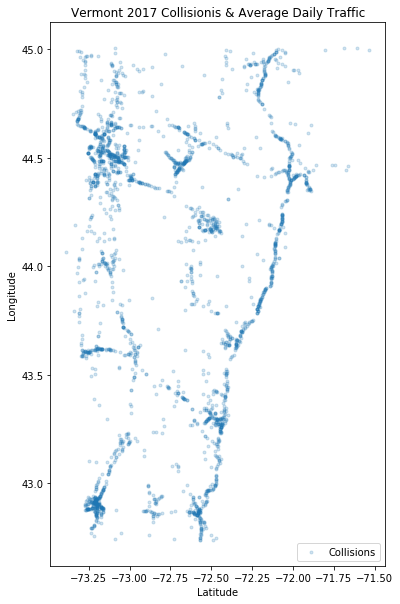

In [27]:
test = df_traffic.dropna(axis='rows', subset=['lat_lon_list', 'line', 'mid_point'])
colors = plt.get_cmap('copper', lut=test.AADT.max())
plt.figure(figsize=(6,10))

"""for index, row in test.iterrows():    
    y, x = test.loc[index, 'line'].xy
    plt.plot(x, y, color=colors(int(test.loc[index, 'AADT'])), zorder=0)"""
    
plt.scatter(df_collisions.lon, df_collisions.lat, 
            marker='.', alpha=.2, c='C0', zorder=1,
            label='Collisions')

plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Vermont 2017 Collisionis & Average Daily Traffic')
plt.legend(loc='lower right')
#plt.colorbar()
#plt.savefig('vt_deer_collisions_190919.svg')
None

# Matching Collisions to road segments

In [35]:
from scipy import spatial

import numpy as np

A = np.random.random((10,2))*100


pt = [60, 60]  # <-- the point to find

spatial.KDTree(A).query(pt)[1] # <-- the nearest point

4

In [36]:
A

array([[66.16956547, 16.19186316],
       [30.55178824, 31.96588562],
       [10.55079362, 65.66327023],
       [71.50001087, 97.3946674 ],
       [48.27144873, 66.50885864],
       [10.12869165,  8.67148423],
       [62.91548035, 40.25460399],
       [11.01928922, 54.44927902],
       [35.42665744, 81.71105112],
       [ 8.8088475 , 59.61314489]])

In [37]:

pt = [60, 60]  # <-- the point to find

spatial.KDTree(A).query(pt)[1] # <-- the nearest point

4

In [38]:
A[9]

array([ 8.8088475 , 59.61314489])

In [39]:
df_traffic.columns

Index(['OBJECTID', 'AADT', 'BeginMM', 'BeginRefName', 'BeginStation', 'CTCode',
       'EndMM', 'EndRefName', 'EndRefNum', 'EndStation', 'ETE_ID',
       'ETE_BeginMM', 'ETE_EndMM', 'FunctionalClass', 'RouteName', 'RouteType',
       'SectionNum', 'StandardRouteCode', 'Status', 'TownName', 'Year',
       'IsDivided', 'lat_lon_list', 'line', 'mid_point', 'ATRStation',
       'ATRStatus', 'BeginRefNum', 'RouteNum'],
      dtype='object')

# Using `rtree` to find nearest roads to collisions
Following [this great example](https://www.azavea.com/blog/2016/10/05/philippines-road-safety-using-shapely-fiona-locate-high-risk-traffic-areas/#step7).

In [59]:
segments_index = rtree.index.Index()
for idx, line in df_traffic.line.items():
    #segments_index.insert(idx, element.bounds)
    print(idx, type(line))

0 <class 'shapely.geometry.linestring.LineString'>
1 <class 'shapely.geometry.linestring.LineString'>
2 <class 'shapely.geometry.linestring.LineString'>
3 <class 'shapely.geometry.linestring.LineString'>
4 <class 'shapely.geometry.linestring.LineString'>
5 <class 'shapely.geometry.linestring.LineString'>
6 <class 'shapely.geometry.linestring.LineString'>
7 <class 'shapely.geometry.linestring.LineString'>
8 <class 'shapely.geometry.linestring.LineString'>
9 <class 'shapely.geometry.linestring.LineString'>
10 <class 'shapely.geometry.linestring.LineString'>
11 <class 'shapely.geometry.linestring.LineString'>
12 <class 'shapely.geometry.linestring.LineString'>
13 <class 'shapely.geometry.linestring.LineString'>
14 <class 'shapely.geometry.linestring.LineString'>
15 <class 'shapely.geometry.linestring.LineString'>
16 <class 'shapely.geometry.linestring.LineString'>
17 <class 'shapely.geometry.linestring.LineString'>
18 <class 'shapely.geometry.linestring.LineString'>
19 <class 'shapely.geo

In [56]:
_test_line = df_traffic.line[0]

In [57]:
_test_line.bounds

(43.646645048106265,
 -72.33550173848928,
 43.646995252339224,
 -72.33476420095099)

Try [this](https://gis.stackexchange.com/questions/227474/rtree-spatial-index-does-not-result-in-faster-intersection-computation).

In [73]:
df_collisions.head()

Unnamed: 0  ObjectID  Mapped           Crash Date    City/Town  \
0         576   1763521     NaN  2009-12-31 20:00:00  Springfield   
1         577   1763656     NaN  2010-01-03 20:00:00      Johnson   
2         578   1763700     NaN  2010-01-04 20:00:00   Bennington   
3         579   1763810     NaN  2010-01-07 20:00:00   Colchester   
4         580   1763840     NaN  2010-01-08 20:00:00       Milton   

                     Address               AOT Route            Crash Type  \
0                   Park St.                 Unknown  Property Damage Only   
1                    VT 100C                 VT-100C  Property Damage Only   
2           US 7 South Bound                    US-7  Property Damage Only   
3  FAU-5600 W. Lakeshore Dr.  VT. 127 TH, COLCHESTER  Property Damage Only   
4               U.S. Route 2                    US-2  Property Damage Only   

            Collision Direction                 Weather  ...  \
0          Single Vehicle Crash                  Cloudy  ...   
1          Single Vehicle Crash  Freezing Precipitation  ...   
2  Other - Explain in Narrative                     NaN  ...   
3          Single Vehicle Crash                     NaN  ...   
4  Other - Explain in Narrative                   Clear  ...   

  Road Characteristics                                     Road Condition  \
0     T - Intersection                                               None   
1    Not at a Junction  Road Surface Condition(wet, icy, snow, slush, ...   
2    Not at a Junction                                               None   
3    Not at a Junction                                            Unknown   
4    Not at a Junction                                               None   

              Street Address  Surface Condition  AOT Route ID  \
0                   Park St.                Wet             0   
1                    VT 100C               Snow          1003   
2           US 7 South Bound               Snow            70   
3  FAU-5600 W. Lakeshore Dr.            Unknown         U5600   
4               U.S. Route 2                Dry            20   

                             Coordinates      time dayofweek        lat  \
0   43.297753600990134,-72.4869377997879  20:00:00  Thursday  43.297754   
1   44.60229674709962,-72.79676066153499  20:00:00    Sunday  44.602297   
2  42.910183864756455,-73.20862715286407  20:00:00    Monday  42.910184   
3   44.54916811489998,-73.22406120316805  20:00:00  Thursday  44.549168   
4    44.61222557703973,-73.2113549256738  20:00:00    Friday  44.612226   

         lon  
0 -72.486938  
1 -72.796761  
2 -73.208627  
3 -73.224061  
4 -73.211355  

[5 rows x 32 columns]

In [79]:
_point = Point(43.297754, -72.486938)

In [82]:
_point.buffer(0.075).bounds

(43.222753999999995, -72.561938, 43.372754, -72.41193799999999)

In [87]:
df_collisions.dropna(subset=['lon', 'lat']).shape

(2574, 32)

In [88]:
df_collisions.shape

(2590, 32)

In [170]:
tolerance=(0.075)/5
crash_box_index = rtree.index.Index()
point_buffers = list()
for idx, row in df_collisions.dropna(subset=['lon', 'lat']).iterrows():
    point = Point(row.lon, row.lat)
    point_buffer = point.buffer(tolerance)
    point_buffers.append(point_buffer)
    crash_box_index.insert(idx, point_buffer.bounds)

In [130]:
point_buffer.bounds

(-73.46881127253847, 43.67614899787082, -71.96881127253847, 45.17614899787082)

# Shortening roads

In [141]:
cutoff = (0.075)/5
series_list, exclude_list = list(), list()
for index, row in df_traffic.dropna(subset=['line']).iterrows():
    if row.line.length > cutoff:
        exclude_list.append(index)
        for line in utilities.split_line(row.line, cutoff):
            temp_series = row.copy()
            temp_series.line = line
            temp_series.mid_point = line.interpolate(0.5, normalized = True)
            series_list.append(temp_series)

mask = ~df_traffic.index.isin(exclude_list)
df_traffic_shortened = df_traffic[mask].append(pd.DataFrame(series_list), ignore_index=True, sort=False)

In [234]:
# Check for Polygons/MultiPolygons that the LineString intersects with
segments_with_records = {}
segment_ids, distances = list(), list()
for line in df_traffic_shortened.dropna(subset=['line']).line[:10]:
    nearby_segments = crash_box_index.intersection(line.bounds)
    inner_dist, inner_id = list(), list()
    for segment_id in nearby_segments:
        inner_id.append(segment_id)
        lon = df_collisions['lon'][segment_id]
        lat = df_collisions['lat'][segment_id]
        collision_point = Point(lon, lat)
        inner_dist.append(collision_point.distance(line))
        segment_id_with_distance.append(tuple([segment_id, distance]))
    segment_ids.append(inner_id)
    distances.append(inner_dist)
    """if len(segment_id_with_distance):
        nearest = min(segment_id_with_distance, key=lambda tup: tup[1])
        segment_id = nearest[0]
        if segment_id not in segments_with_records:
            segments_with_records[segment_id] = []"""

In [235]:
len(distances)

10

In [236]:
len(segment_ids)

10

In [239]:
nearby_segments

<generator object Index._get_ids at 0x7fb703858350>

In [238]:
distances[-1]

[0.009032131551800418, 0.010451682728610903]

In [240]:
distances.index(min(distances))

7

In [242]:
segment_ids[-1]

[895, 1048]

In [227]:
collision_point.xy

(array('d', [-73.20411132402889]), array('d', [43.097873192963014]))

In [229]:
df_collisions.iloc[100,:]

Unnamed: 0                                                              675
ObjectID                                                            1768707
Mapped                                                                  NaN
Crash Date                                              2010-06-28 21:00:00
City/Town                                                          Hartford
Address                                                  VT-14 Maple Street
AOT Route                                                             VT-14
Crash Type                                                           Injury
Collision Direction                                                 Head On
Weather                                                               Clear
Road Group                State System (State Highways and Class I TH li...
Report Number                                                     10HF02626
Reporting Agency                                               Hartford PD.
Road Group I

In [223]:
line.xy

(array('d', [-73.11455490284747, -73.11458342758377, -73.1146420907046, -73.1147031287851, -73.1147965475845, -73.11493565835822, -73.11507225075664, -73.11525549231362, -73.11540781414449, -73.11550092895577, -73.11561041282926, -73.11572714556816, -73.11584526482119, -73.11594690246488, -73.11606624131291, -73.11621364775506, -73.1163308473167, -73.1164934790407, -73.11666545285976, -73.11688404545563, -73.11711509507653, -73.11733652721996, -73.11757616753785, -73.1178752652595, -73.11816163588486, -73.11857331402508, -73.11910551907694, -73.11954775485167, -73.11974403284204, -73.11989364561703, -73.12001453053439, -73.12009668901172, -73.12017246431654, -73.1202451840494, -73.12030411077255, -73.12034333071621, -73.12036696875965, -73.12040058161055, -73.12041942947651, -73.120416101634, -73.12039995551011, -73.12037811113424, -73.12034377063708, -73.1202994446567, -73.1202475341409, -73.12013167681296, -73.12005215707973, -73.11992875799868, -73.11980131828301, -73.11966730779699

## Double checking that my lon/lat is okay
I'm going insane.

In [214]:
df_traffic_shortened.shape

(7453, 30)

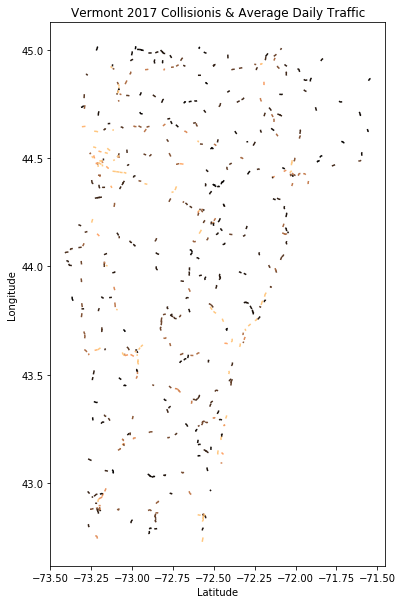

In [213]:
test = df_traffic_shortened.dropna(axis='rows', subset=['lat_lon_list', 'line', 'mid_point'])
colors = plt.get_cmap('copper', lut=test.AADT.max())
plt.figure(figsize=(6,10))

for index, row in test.sample(500).iterrows():    
    x, y = test.loc[index, 'line'].xy
    plt.plot(x, y, color=colors(int(test.loc[index, 'AADT'])), zorder=0)
    

plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Vermont 2017 Collisionis & Average Daily Traffic')
#plt.colorbar(colors)
#plt.savefig('vt_deer_collisions_2017_avg_daily_traffic.svg')
None

In [185]:
len(segment_id_with_distance)

0

In [176]:
segments_with_records

{319: [],
 1894: [],
 834: [],
 96: [],
 1048: [],
 336: [],
 1537: [],
 968: [],
 895: [],
 2099: [],
 2403: [],
 1446: [],
 317: [],
 697: [],
 904: [],
 1212: [],
 379: [],
 1945: [],
 528: [],
 2053: [],
 1606: [],
 121: [],
 182: [],
 1704: [],
 815: [],
 488: [],
 754: [],
 959: [],
 1075: [],
 2211: [],
 105: [],
 2484: [],
 1620: [],
 1376: [],
 2489: [],
 806: [],
 1551: [],
 43: [],
 1356: [],
 1333: [],
 2434: [],
 1829: [],
 738: [],
 1888: [],
 1613: [],
 1971: [],
 1268: [],
 1690: [],
 143: [],
 1956: [],
 1054: [],
 2380: [],
 23: [],
 1113: [],
 546: [],
 2258: [],
 1558: [],
 2073: [],
 2365: [],
 235: [],
 1911: [],
 780: [],
 1659: [],
 2428: [],
 241: [],
 1081: [],
 1550: [],
 851: [],
 2074: [],
 240: [],
 2548: [],
 1077: [],
 1868: [],
 222: [],
 862: [],
 378: [],
 681: [],
 1540: [],
 346: [],
 2491: [],
 1909: [],
 2396: [],
 341: [],
 2577: [],
 204: [],
 1158: [],
 160: [],
 2284: [],
 1427: [],
 1228: [],
 1467: [],
 232: [],
 2014: [],
 1820: [],
 2242: 

In [ ]:
segments_with_records = {}
for record in records:
    record_point = record['point']
    record_buffer_bounds = record_point.buffer(match_tolerance).bounds
    nearby_segments = segments_index.intersection(record_buffer_bounds)
    segment_id_with_distance = [
        (segment_id, combined_segments[segment_id].distance(record_point))
        for segment_id in nearby_segments
    ]
    if len(segment_id_with_distance):
        nearest = min(segment_id_with_distance, key=lambda tup: tup[1])
        segment_id = nearest[0]
        if segment_id not in segments_with_records:
            segments_with_records[segment_id] = []

In [116]:
covered_polygons

{}

In [161]:
_line = df_traffic_shortened.line[0].bounds

In [162]:
_line

(-72.33550173848928,
 43.646645048106265,
 -72.33476420095099,
 43.646995252339224)

In [167]:
list(crash_box_index.intersection(_line))

[319, 75]

## Making `KDTree` for VT AADT Segment Midpoints

In [244]:
from scipy import spatial
mid_points = np.zeros((df_traffic_shortened.mid_point.shape[0], 2))
for n, mpoint in enumerate(df_traffic_shortened.mid_point):
    if type(mpoint)==float:
        pass
    else:
        mid_points[n] = list(mpoint.coords)[0]

mid_point_tree = spatial.KDTree(mid_points)

In [245]:
df_traffic.mid_point.iloc[-1].xy

(array('d', [-72.40216790260554]), array('d', [44.99565537119512]))

In [246]:
mid_points[-5:]

array([[-73.15787062,  43.07651361],
       [-73.11209537,  43.4416447 ],
       [-73.10899173,  43.45320784],
       [-73.11311788,  43.46457618],
       [-73.11878115,  43.47479518]])

In [247]:
df_collisions.iloc[0].lat

43.297753600990134

In [ ]:
mid_point_tree.query([])

In [248]:
aadt_index_nums, distances = list(), list()
for index, row in df_collisions.iterrows():
    #print(row.lat, row.lon)
    dist, num = mid_point_tree.query([row.lon, row.lat])
    aadt_index_nums.append(num)
    distances.append(dist)
    #print(num, end=', ')

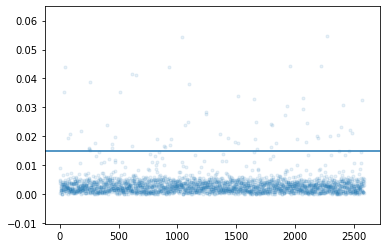

In [249]:
plt.scatter(range(len(distances)), distances, marker='.', alpha=.1)
plt.axhline(0.07381197609536122/5)

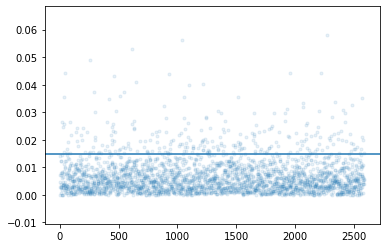

In [114]:
plt.scatter(range(len(distances)), distances, marker='.', alpha=.1)
plt.axhline(0.07381197609536122/5)

max_line_units=0.07381197609536122
    is set for 5 mile increments

In [256]:
len(aadt_index_nums)

2590

In [257]:
df_collisions.shape

(2590, 32)

In [258]:
df_collisions["traffic_index"] = aadt_index_nums

In [271]:
df_traffic_shortened.shape

(7453, 30)

In [273]:
max(aadt_index_nums)

7453

In [277]:
df_collisions.head()

Unnamed: 0  ObjectID  Mapped           Crash Date    City/Town  \
0         576   1763521     NaN  2009-12-31 20:00:00  Springfield   
1         577   1763656     NaN  2010-01-03 20:00:00      Johnson   
2         578   1763700     NaN  2010-01-04 20:00:00   Bennington   
3         579   1763810     NaN  2010-01-07 20:00:00   Colchester   
4         580   1763840     NaN  2010-01-08 20:00:00       Milton   

                     Address               AOT Route            Crash Type  \
0                   Park St.                 Unknown  Property Damage Only   
1                    VT 100C                 VT-100C  Property Damage Only   
2           US 7 South Bound                    US-7  Property Damage Only   
3  FAU-5600 W. Lakeshore Dr.  VT. 127 TH, COLCHESTER  Property Damage Only   
4               U.S. Route 2                    US-2  Property Damage Only   

            Collision Direction                 Weather  ...  \
0          Single Vehicle Crash                  Cloudy  ...   
1          Single Vehicle Crash  Freezing Precipitation  ...   
2  Other - Explain in Narrative                     NaN  ...   
3          Single Vehicle Crash                     NaN  ...   
4  Other - Explain in Narrative                   Clear  ...   

                                      Road Condition  \
0                                               None   
1  Road Surface Condition(wet, icy, snow, slush, ...   
2                                               None   
3                                            Unknown   
4                                               None   

              Street Address Surface Condition  AOT Route ID  \
0                   Park St.               Wet             0   
1                    VT 100C              Snow          1003   
2           US 7 South Bound              Snow            70   
3  FAU-5600 W. Lakeshore Dr.           Unknown         U5600   
4               U.S. Route 2               Dry            20   

                             Coordinates      time dayofweek        lat  \
0   43.297753600990134,-72.4869377997879  20:00:00  Thursday  43.297754   
1   44.60229674709962,-72.79676066153499  20:00:00    Sunday  44.602297   
2  42.910183864756455,-73.20862715286407  20:00:00    Monday  42.910184   
3   44.54916811489998,-73.22406120316805  20:00:00  Thursday  44.549168   
4    44.61222557703973,-73.2113549256738  20:00:00    Friday  44.612226   

         lon traffic_index  
0 -72.486938          1672  
1 -72.796761          6634  
2 -73.208627          5753  
3 -73.224061          2296  
4 -73.211355          5140  

[5 rows x 33 columns]

In [357]:
traffic_collision_series = df_collisions.groupby('traffic_index').count().ObjectID

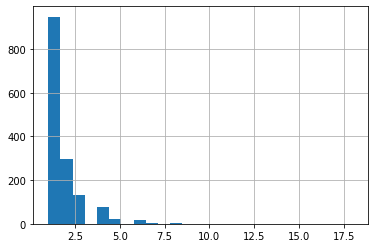

In [286]:
traffic_collision_series.hist(bins=25)
None

In [358]:
traffic_collision_series.index

Int64Index([  21,   44,   66,   74,   79,   83,   85,   89,   92,   95,
            ...
            7399, 7402, 7412, 7413, 7415, 7416, 7417, 7432, 7442, 7453],
           dtype='int64', name='traffic_index', length=1507)

In [359]:
df_traffic.shape

(3543, 30)

In [388]:
df_traffic_shortened.iloc[traffic_collision_series.index[:-1],:].shape

(1506, 30)

In [360]:
collision_per_traffic = df_traffic_shortened.copy().iloc[traffic_collision_series.index[:-1],:]
collision_per_traffic.loc[:,'AADT'] = collision_per_traffic.AADT.astype(int).values

In [361]:
collision_per_traffic.shape

(1506, 30)

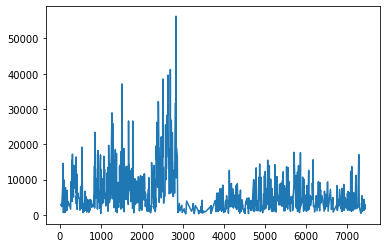

In [362]:
plt.plot(collision_per_traffic.AADT)

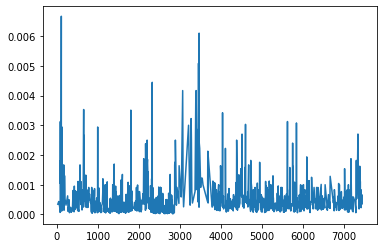

In [363]:
plt.plot(traffic_collision_series.iloc[:-1] / collision_per_traffic.AADT)

In [368]:
collision_per_traffic['collision_per_aadt'] = traffic_collision_series.iloc[:-1] / collision_per_traffic.AADT
#collision_per_traffic.normal_aadt /= collision_per_traffic.normal_aadt.max()

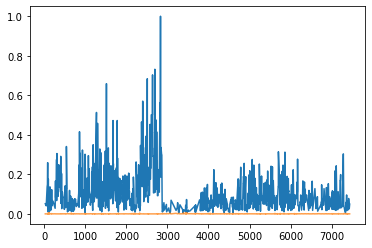

In [365]:
plt.plot(collision_per_traffic.AADT / collision_per_traffic.AADT.max())

plt.plot(collision_per_traffic.collision_per_aadt, alpha=.75)
#collision_per_traffic.normal_aadt.plot()

## Doing things with normalized collision data

- Okay so make a new traffic dataframe with only the indices in `df_collisions.traffic_index`. 
- Then I can normalize the `df_traffic_new.AADT` number by the count of collisions in the index that I make with `groupby`

# Looking at line segment lengths

In [85]:
collision_per_traffic.columns

Index(['OBJECTID', 'AADT', 'BeginMM', 'BeginRefName', 'BeginStation', 'CTCode',
       'EndMM', 'EndRefName', 'EndRefNum', 'EndStation', 'ETE_ID',
       'ETE_BeginMM', 'ETE_EndMM', 'FunctionalClass', 'RouteName', 'RouteType',
       'SectionNum', 'StandardRouteCode', 'Status', 'TownName', 'Year',
       'IsDivided', 'lat_lon_list', 'line', 'mid_point', 'ATRStation',
       'ATRStatus', 'BeginRefNum', 'RouteNum', 'normal_aadt'],
      dtype='object')

In [297]:
lengths = np.array([line.length for line in collision_per_traffic.line])

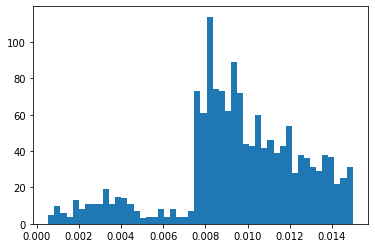

In [298]:
plt.hist(lengths, bins=50)
None

In [299]:
lengths.max()

0.014983331175983779

In [300]:
lengths.mean()

0.009558166420091222

# Working with buffered line segments
[Here](https://shapely.readthedocs.io/en/stable/manual.html#object.buffer) is the documentation for `buffer`.

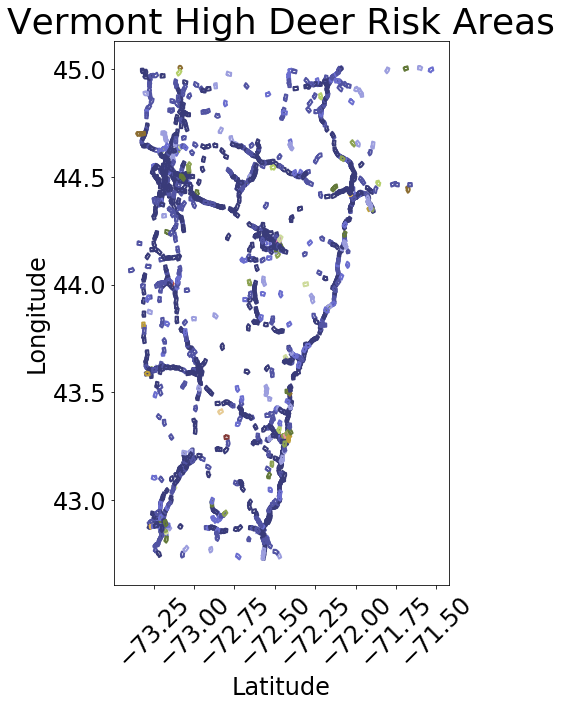

In [414]:
test = collision_per_traffic.dropna(axis='rows', subset=['lat_lon_list', 'line', 'mid_point'])
colors = plt.get_cmap('tab20b') # , lut=test.collision_per_aadt.max())
plt.figure(figsize=(3*2,5*2))
_normal = test.collision_per_aadt.max()

for index, row in test.iloc[:,:].iterrows(): 
    poly = row.line.buffer(.0075, cap_style=3)
    test_shape = poly.simplify(0.0001, preserve_topology=False)
    x, y = poly.exterior.xy
    plt.plot(x, y, 
             color=colors(row.collision_per_aadt/_normal),
             lw=2, alpha=1)

plt.xlabel('Latitude', fontsize=24)
plt.ylabel('Longitude', fontsize=24)
plt.title('Vermont High Deer Risk Areas', fontsize=36)
plt.xticks(fontsize=24, rotation=45)
plt.yticks(fontsize=24)
#plt.legend(loc='lower right')
#plt.colorbar()
#plt.savefig('vt_deer_collisions_per_avg_daily_traffic_190919.svg')
None

# Saving a shapefile with `geopandas`

In [384]:
import geopandas
geodf = geopandas.GeoDataFrame(test[['line', 'collision_per_aadt']], geometry='line')
#geodf.to_file('test_geometries.shp', driver='ESRI Shapefile')

In [408]:
mask_collisions = df_traffic_shortened.index.isin(traffic_collision_series.index[:-1])
sample = df_traffic_shortened[~mask_collisions].sample(1500, random_state=0)
no_crash_geodf = geopandas.GeoDataFrame(sample['line'], geometry='line')
no_crash_geodf['collision'] = 0
no_crash_geodf.dropna(inplace=True)
#no_crash_geodf.to_file('no_crash_geometries_191001.shp', driver='ESRI Shapefile')

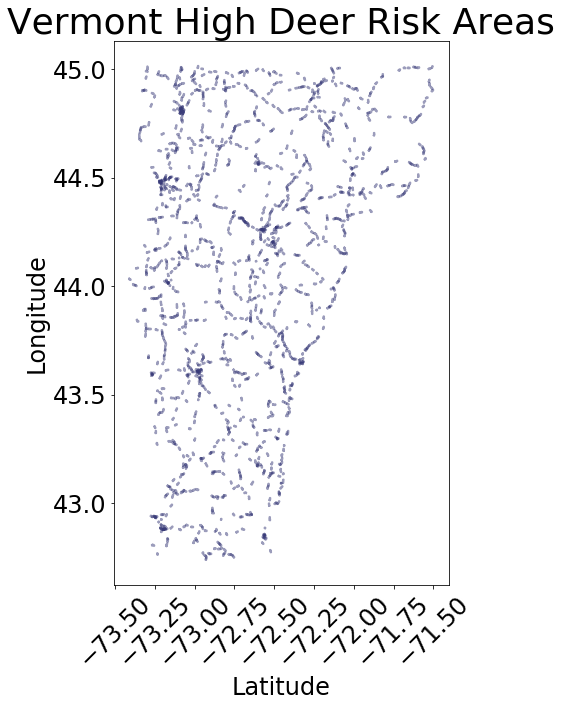

In [409]:
#test = collision_per_traffic.dropna(axis='rows', subset=['lat_lon_list', 'line', 'mid_point'])
colors = plt.get_cmap('tab20b') #, lut=test.normal_aadt.max())
plt.figure(figsize=(3*2,5*2))
polygons = list()

for index, row in no_crash_geodf.iloc[:,:].iterrows(): 
    poly = row.line.buffer((.0075)/5, cap_style=3)
    polygons.append(poly)
    x, y = poly.exterior.xy
    plt.plot(x, y, 
             color=colors(row.collision),
             lw=2, alpha=.5)

plt.xlabel('Latitude', fontsize=24)
plt.ylabel('Longitude', fontsize=24)
plt.title('Vermont High Deer Risk Areas', fontsize=36)
plt.xticks(fontsize=24, rotation=45)
plt.yticks(fontsize=24)
#plt.legend(loc='lower right')
#plt.colorbar()
#plt.savefig('vt_deer_collisions_per_avg_daily_traffic_190919.svg')
None

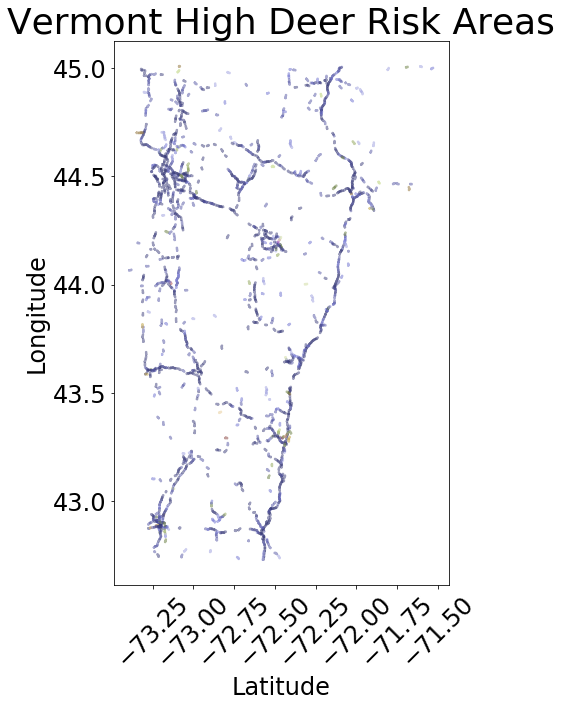

In [339]:
#test = collision_per_traffic.dropna(axis='rows', subset=['lat_lon_list', 'line', 'mid_point'])
colors = plt.get_cmap('tab20b') #, lut=test.normal_aadt.max())
plt.figure(figsize=(3*2,5*2))
polygons = list()

for index, row in geodf.iloc[:,:].iterrows(): 
    poly = row.line.buffer((.0075)/5, cap_style=3)
    polygons.append(poly)
    x, y = poly.exterior.xy
    plt.plot(x, y, 
             color=colors(row.normal_aadt),
             lw=2, alpha=.5)

plt.xlabel('Latitude', fontsize=24)
plt.ylabel('Longitude', fontsize=24)
plt.title('Vermont High Deer Risk Areas', fontsize=36)
plt.xticks(fontsize=24, rotation=45)
plt.yticks(fontsize=24)
#plt.legend(loc='lower right')
#plt.colorbar()
#plt.savefig('vt_deer_collisions_per_avg_daily_traffic_190919.svg')
None

In [334]:
geojson = geopandas.GeoSeries(polygons).__geo_interface__
viz = LinestringViz(geojson, 
                    access_token=token,
                    #color_property=geodf.normal_aadt.values,
                    #color_stops=create_color_stops([0, 50, 100, 500, 1500], colors='Blues'),
                    line_stroke='-',
                    line_width_property='weight',
                    line_width_stops=create_numeric_stops([0, 1, 2, 3, 4, 5], 0, 10),
                    opacity=0.8,
                    center=(-75, 45),
                    zoom=4,
                    below_layer='waterway-label')
viz.show()

In [22]:
temp = df_collisions.dropna(axis='rows', subset=['lat', 'lon'], how='any')[['lat', 'lon']]
geojson = df_to_geojson(temp, lat='lat', lon='lon', precision=10)
viz = CircleViz(geojson, access_token=token, 
                radius = 2, center = (temp.lon.mean(), temp.lat.mean()), 
                zoom = 7,
                below_layer='waterway-label')
viz.show()

/home/jeremy/.anaconda3/envs/inaturalist/lib/python3.7/site-packages/IPython/core/display.py:694: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## File IO

In [344]:
_testgeodf = geopandas.read_file('test_geometries.shp')

In [345]:
_testgeodf.head()

normal_aad                                           geometry
0    0.051724  LINESTRING (-73.20970418741922 44.467297895026...
1    0.065217  LINESTRING (-72.66058103070257 42.816127191201...
2    0.038961  LINESTRING (-72.30824588902144 43.713538389200...
3    0.017857  LINESTRING (-72.5741598849302 44.2142368414836...
4    0.010274  LINESTRING (-73.00411822391678 43.604181401677...

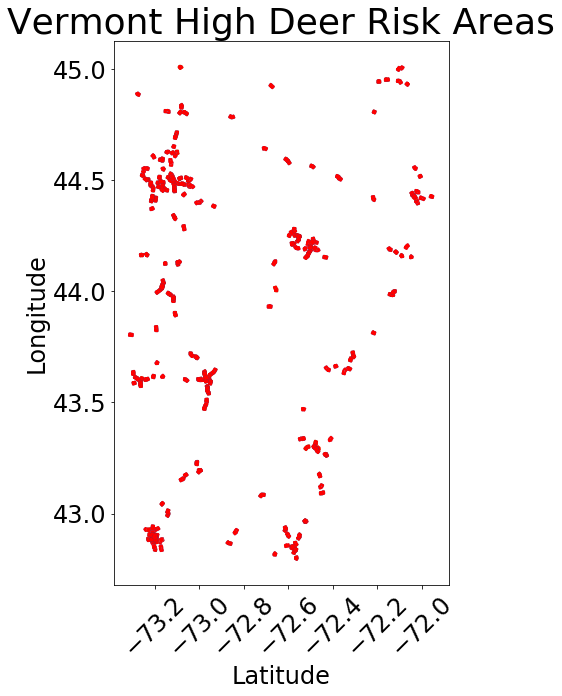

In [350]:
#test = collision_per_traffic.dropna(axis='rows', subset=['lat_lon_list', 'line', 'mid_point'])
colors = plt.get_cmap('tab20b') #, lut=test.normal_aadt.max())
plt.figure(figsize=(3*2,5*2))

for index, row in _testgeodf.iloc[:300,:].iterrows(): 
    poly = row.geometry.buffer(5e-3, cap_style=3)
    test_shape = poly.simplify(0.001, preserve_topology=False)
    #print(len(poly.exterior.coords))
    #print(len(test_shape.exterior.coords))
    x, y = poly.exterior.xy
    plt.plot(x, y, 
             color=colors(row.normal_aad),
             lw=2, alpha=1)
    
    x, y = test_shape.exterior.xy
    plt.plot(x, y, 
             color='red',
             lw=2, alpha=1)

plt.xlabel('Latitude', fontsize=24)
plt.ylabel('Longitude', fontsize=24)
plt.title('Vermont High Deer Risk Areas', fontsize=36)
plt.xticks(fontsize=24, rotation=45)
plt.yticks(fontsize=24)
#plt.legend(loc='lower right')
#plt.colorbar()
#plt.savefig('vt_deer_collisions_per_avg_daily_traffic_190919.svg')
None

In [351]:
_testgeodf.loc[0, 'geometry'].coords

## Simplifying buffer shapes

```python
>>> p = Point(0.0, 0.0)
>>> x = p.buffer(1.0)
>>> x.area
3.1365484905459389
>>> len(x.exterior.coords)
66
>>> s = x.simplify(0.05, preserve_topology=False)
>>> s.area
3.0614674589207187
>>> len(s.exterior.coords)
17
```

In [374]:
bboxstr = '(poly:"{}")'.format(
            ' '.join('{c[0]} {c[1]}'.format(c=c) for c in test_shape.exterior.coords[:]))

In [375]:
bboxstr

'(poly:"44.158707895356514 -72.45138848517236 44.16107891608033 -72.44911670704812 44.15898197436062 -72.45251631667031 44.158707895356514 -72.45138848517236")'

In [362]:
row

normal_aad                                                0.085
geometry      LINESTRING (44.15899228768008 -72.451809285104...
Name: 2, dtype: object

In [338]:
test.exterior.coords

In [264]:
for c in poly.exterior.coords:
    print(c)

(44.835111358645065, -73.07816286614955)
(44.8354431090691, -73.07778885711967)
(44.83559004198415, -73.07763393222226)
(44.83561732616617, -73.0776000657186)
(44.8358638875001, -73.07730945581588)
(44.83599818082748, -73.07715908837719)
(44.83618263830669, -73.07694868383008)
(44.83649395302422, -73.07657821574094)
(44.837165304456185, -73.07576553912632)
(44.841941957094484, -73.0699833605081)
(44.853506314330936, -73.0795366657847)
(44.848038251946704, -73.08615580177707)
(44.847997932107674, -73.08620419398413)
(44.84761586317839, -73.08665886039785)
(44.847513631417684, -73.08677796432578)
(44.847254667654184, -73.0870733557277)
(44.84720889502849, -73.08712508455822)
(44.84717161965315, -73.08716682157393)
(44.84705956252569, -73.08730194145704)
(44.846938071324736, -73.08744427655564)
(44.846807940520335, -73.08759273149468)
(44.846680785291525, -73.08773399703375)
(44.846548201930894, -73.08787748959399)
(44.84649882850664, -73.08792954853998)
(44.846368718405245, -73.088086470

### Converting length to meters
From [GIS StackExchange](https://gis.stackexchange.com/questions/80881/what-is-unit-of-shapely-length-attribute).

I don't know about using this. It will change the length of the lines that I'm dealing with and I won't be able to plot them as easily.

I'll come back to this if I need it.

In [149]:
from shapely.geometry import LineString
from shapely.ops import transform
from functools import partial
import pyproj

line1 = LineString([(15.800657, 40.64), (15.810173,40.64)])
print(str(line1.length) + " degrees")
# 0.0115488362184 degrees

# Geometry transform function based on pyproj.transform
project = partial(
    pyproj.transform,
    pyproj.Proj(init='EPSG:4326'),
    pyproj.Proj(init='EPSG:32633'))

line2 = transform(project, line1)
print(str(line2.length) + " meters")

0.009516000000001412 degrees
804.6947135120693 meters


In [83]:
line2.xy

(array('d', [567600.0409324057, 568506.2680250241]),
 array('d', [4498665.680008891, 4499137.674038483]))

In [84]:
line1.xy

(array('d', [15.799406, 15.810173]), array('d', [40.636069, 40.640246]))